In [ ]:
# Import packages
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Set option to display all columns and rows
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# Set option to force dataframes to display numbers as floats with thousands separators
pd.set_option('display.float_format', '{:,.3f}'.format)  # Adjust decimal places as needed

Check https://www.kaggle.com/code/rikdifos/eda-vintage-analysis/notebook for variable definitions

### Data Preparation

In [ ]:
# ------------------------------------------------------------------------
# 1. Load and inspect the data
# ------------------------------------------------------------------------
# Define the directory containing the CSV files
directory = ''

# Open the files in a DataFrame for viewing
application_raw_file = os.path.join(directory, 'application_record.csv')
app_record = pd.read_csv(application_raw_file)

credit_raw_file = os.path.join(directory, 'credit_record.csv')
credit_record = pd.read_csv(credit_raw_file)

Checking for duplicates by ID

In [40]:
# Identify IDs in app_record that appear more than once
duplicate_ids = app_record['ID'].value_counts()[lambda x: x > 1].index
duplicate_ids

Index([7137299, 7702238, 7282535, 7243768, 7050948, 7602432, 7036518, 7045885,
       7618285, 7089090, 7052783, 7416167, 7023108, 7045794, 7053557, 7207977,
       7836711, 7772847, 7154819, 7052812, 7099881, 7022327, 7833087, 7743418,
       7836971, 7372589, 7636756, 7636389, 7213374, 7317997, 7838075, 7023651,
       7155150, 7091721, 7046068, 7742298, 7744386, 7702516, 7022197, 7154598,
       7742853, 7090931, 7135270, 7024111, 7174719, 7603224, 7576316],
      dtype='int64', name='ID')

This ID example appears to be two completely unrelated people

In [41]:
app_record[app_record['ID'] == 7022197]

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS
425023,7022197,F,N,Y,0,"450,000.000",Commercial associate,Higher education,Separated,House / apartment,-19813,-1799,1,0,0,1,NaN,1.000
426818,7022197,M,Y,Y,3,"135,000.000",Working,Secondary / secondary special,Married,House / apartment,-11945,-735,1,0,0,1,Laborers,5.000


Fortunately the duplicated IDs don't exist in the credit record file

In [42]:
# Filter credit_record to include only rows with duplicate IDs from app_record
credit_record_duplicates = credit_record[credit_record['ID'].isin(duplicate_ids)]

print(credit_record_duplicates)

Empty DataFrame
Columns: [ID, MONTHS_BALANCE, STATUS]
Index: []


Remove duplicates in application record

In [43]:
app_record = app_record.groupby('ID').filter(lambda x: len(x) == 1)

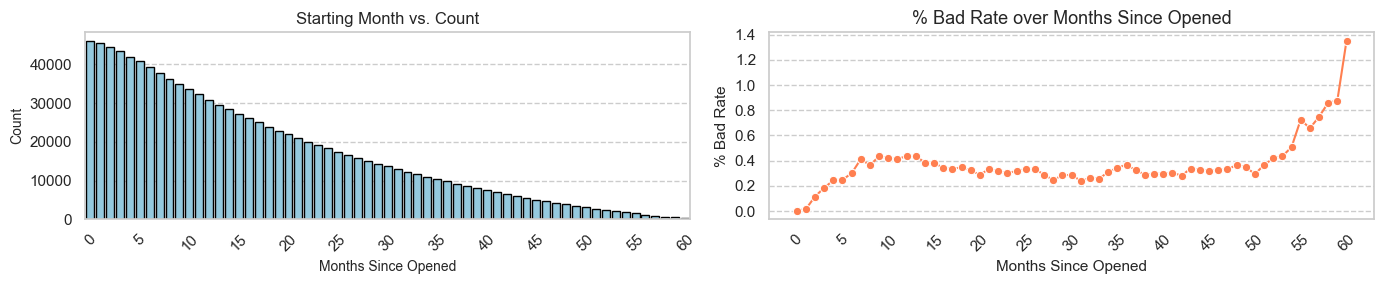

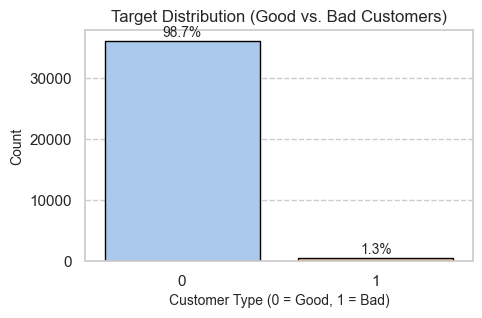

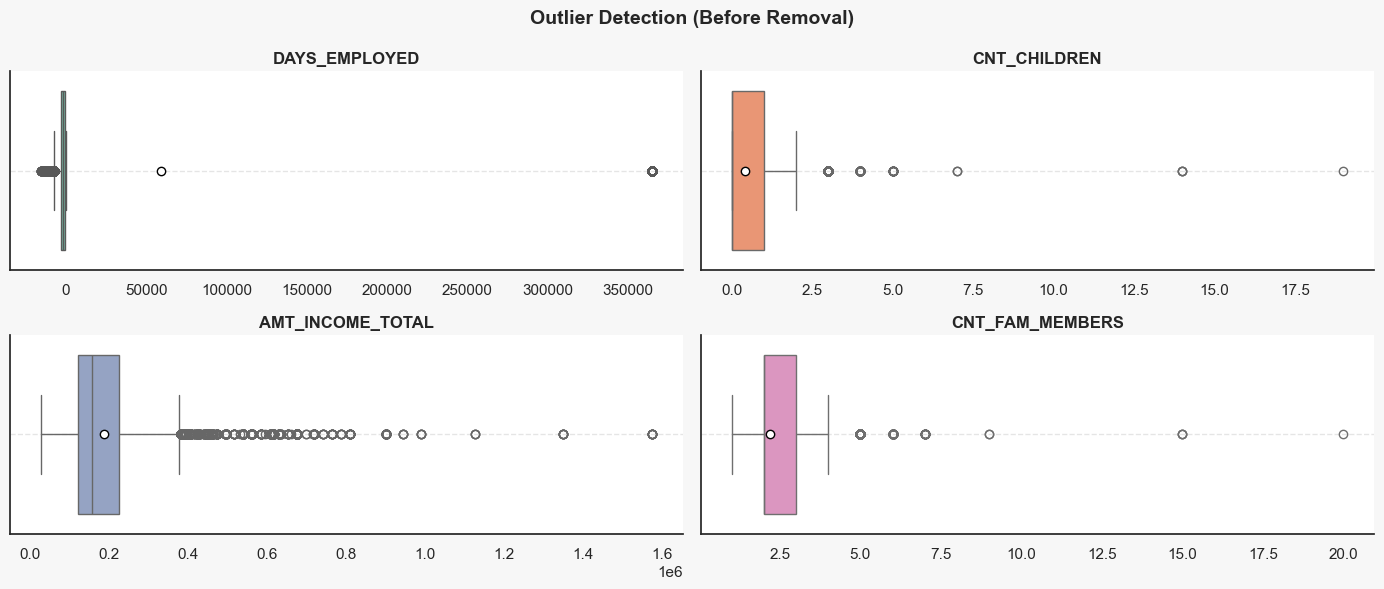

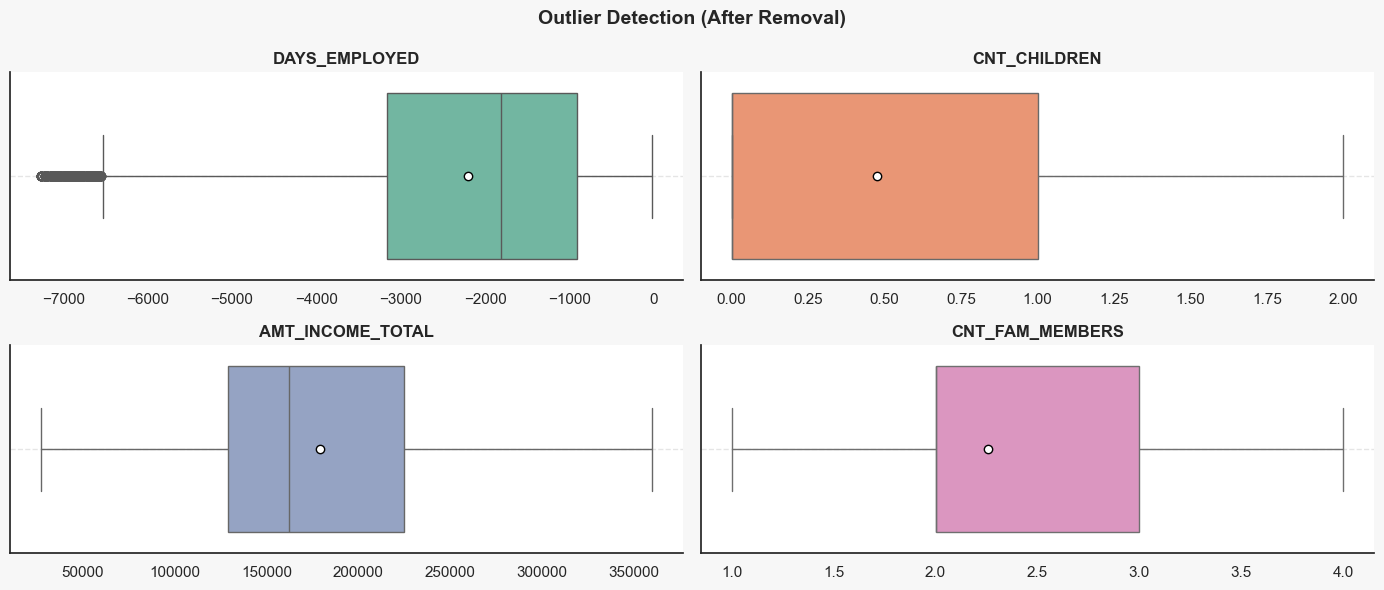

Original merged data shape: (36457, 19)
After outlier removal: (26663, 19)


In [44]:
# ------------------------------------------------------------------------
# 2. Determine the opening month for each customer
# ------------------------------------------------------------------------
opening_months = credit_record.groupby('ID')['MONTHS_BALANCE'].min().rename('opening_month')
credit_record = credit_record.merge(opening_months, on='ID', how='left')
credit_record['MONTHS_SINCE_OPENED'] = credit_record['MONTHS_BALANCE'] - credit_record['opening_month']

# ------------------------------------------------------------------------
# Visualize “Starting Month vs. Count” and Monthly Bad Rate
# ------------------------------------------------------------------------
sns.set_style("whitegrid")
month_distribution = credit_record.groupby('MONTHS_SINCE_OPENED')['ID'].count()

fig, ax = plt.subplots(1, 2, figsize=(14, 3))

# Left subplot: Starting Month vs. Count
sns.barplot(
    x=month_distribution.index,
    y=month_distribution.values,
    ax=ax[0],
    color='skyblue',
    edgecolor='black'
)
ax[0].set_xlabel('Months Since Opened', fontsize=10)
ax[0].set_ylabel('Count', fontsize=10)
ax[0].set_title('Starting Month vs. Count', fontsize=12)
ax[0].xaxis.set_major_locator(ticker.MultipleLocator(5))
ax[0].tick_params(axis='x', rotation=45)
ax[0].grid(True, which='both', axis='y', linestyle='--')
ax[0].grid(False, which='both', axis='x')

# Right subplot: Monthly Bad Rate
credit_record['bad_flag'] = credit_record['STATUS'].isin(['2','3','4','5']).astype(int)
bad_rate_df = credit_record.groupby('MONTHS_SINCE_OPENED')['bad_flag'].mean() * 100

sns.lineplot(
    x=bad_rate_df.index,
    y=bad_rate_df.values,
    ax=ax[1],
    color='coral',
    marker='o'
)
ax[1].set_xlabel('Months Since Opened', fontsize=11)
ax[1].set_ylabel('% Bad Rate', fontsize=11)
ax[1].set_title('% Bad Rate over Months Since Opened', fontsize=13)
ax[1].xaxis.set_major_locator(ticker.MultipleLocator(5))
ax[1].yaxis.set_major_locator(ticker.MultipleLocator(0.2))
ax[1].tick_params(axis='x', rotation=45)
ax[1].grid(True, which='both', axis='y', linestyle='--')
ax[1].grid(False, which='both', axis='x')

plt.tight_layout()
plt.show()

# ------------------------------------------------------------------------
# 3. Create the target variable (1=bad, 0=good) based on first 12 months
# ------------------------------------------------------------------------
first_year = credit_record[credit_record['MONTHS_SINCE_OPENED'] <= 12]
target_per_id = first_year.groupby('ID')['bad_flag'].max().rename('target')

# Use an inner join so only customers with 12-month coverage are included
app_record = app_record.merge(target_per_id, on='ID', how='inner')

# ------------------------------------------------------------------------
# Target Distribution (Good vs. Bad Customers)
# ------------------------------------------------------------------------
sns.set_style("whitegrid")
target_counts = app_record['target'].value_counts().sort_index()  # ensures order: 0 then 1

df_target = target_counts.reset_index()
df_target.columns = ['customer_type', 'count']

fig, ax = plt.subplots(figsize=(5, 3))
sns.barplot(
    data=df_target,
    x='customer_type',
    y='count',
    hue='customer_type',
    palette="pastel",
    dodge=False,
    edgecolor="black",
    ax=ax
)
if ax.get_legend() is not None:
    ax.legend_.remove()

ax.set_xlabel("Customer Type (0 = Good, 1 = Bad)", fontsize=10)
ax.set_ylabel("Count", fontsize=10)
ax.set_title("Target Distribution (Good vs. Bad Customers)", fontsize=12)
ax.grid(True, which='both', axis='y', linestyle='--')
ax.grid(False, which='both', axis='x')

total = target_counts.sum()
percentages = (target_counts / total * 100).round(1)
for i, row in df_target.iterrows():
    ax.text(i, row['count'] + total * 0.005, f"{percentages[i]}%", ha='center', va='bottom', fontsize=10)

plt.show()

# ------------------------------------------------------------------------
# 4. Handling Outliers (Visualization and Removal)
# ------------------------------------------------------------------------
def plot_boxplots(data, columns, title):
    """
    Plots a 2x2 grid of horizontal boxplots for the specified columns
    with cleaner styling (dashed horizontal grid, no vertical grid).
    """
    sns.set_theme(style='white', font_scale=1.0)
    custom_colors = sns.color_palette("Set2", n_colors=len(columns))

    fig, axes = plt.subplots(2, 2, figsize=(14, 6), facecolor="#F7F7F7")
    axes = axes.flatten()

    for i, col in enumerate(columns):
        sns.boxplot(
            data=data,
            x=col,
            ax=axes[i],
            color=custom_colors[i],
            showmeans=True,
            meanprops={
                "marker": "o",
                "markerfacecolor": "white",
                "markeredgecolor": "black",
                "markersize": 6
            }
        )
        axes[i].set_title(col, fontsize=12, fontweight='semibold')
        axes[i].set_xlabel("")
        axes[i].set_ylabel("")
        axes[i].grid(True, which='major', axis='y', linestyle='--', alpha=0.5)
        axes[i].grid(False, which='major', axis='x')
        sns.despine(ax=axes[i], left=False, bottom=False)

    fig.suptitle(title, fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

# Columns to inspect for outliers
columns_of_interest = ["DAYS_EMPLOYED", "CNT_CHILDREN", "AMT_INCOME_TOTAL", "CNT_FAM_MEMBERS"]

# Visualize the original data (Before Outlier Removal)
plot_boxplots(app_record, columns_of_interest, title="Outlier Detection (Before Removal)")

def remove_outliers_iqr(df, col):
    """
    Removes outliers from df[col] based on the 1.5*IQR rule.
    Returns a filtered DataFrame with outliers removed.
    """
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_fence = Q1 - 1.5 * IQR # post outlier removal figures look closer to the paper if we use 3.0 instead 1.5 here
    upper_fence = Q3 + 1.5 * IQR # post outlier removal figures look closer to the paper if we use 3.0 instead 1.5 here
    return df[(df[col] >= lower_fence) & (df[col] <= upper_fence)]

# Create a copy for outlier removal
app_record_clean = app_record.copy()

# Encode flags to numeric
app_record_clean['CODE_GENDER'] = app_record_clean['CODE_GENDER'].map({'M': 1, 'F': 0})
app_record_clean['FLAG_OWN_CAR'] = app_record_clean['FLAG_OWN_CAR'].map({'Y': 1, 'N': 0})
app_record_clean['FLAG_OWN_REALTY'] = app_record_clean['FLAG_OWN_REALTY'].map({'Y': 1, 'N': 0})

# Apply IQR rule to each column in columns_of_interest
for col in columns_of_interest:
    app_record_clean = remove_outliers_iqr(app_record_clean, col)

# Visualize the clean data (After Outlier Removal)
plot_boxplots(app_record_clean, columns_of_interest, title="Outlier Detection (After Removal)")

# Optional: Print shape changes or summary stats
print("Original merged data shape:", app_record.shape)
print("After outlier removal:", app_record_clean.shape)

Preview of final DataFrame:
         ID  CODE_GENDER  FLAG_OWN_CAR  FLAG_OWN_REALTY  CNT_CHILDREN  \
2  5008806            1             1                1             0   
3  5008808            0             0                1             0   
4  5008809            0             0                1             0   
5  5008810            0             0                1             0   
6  5008811            0             0                1             0   

   AMT_INCOME_TOTAL      NAME_INCOME_TYPE            NAME_EDUCATION_TYPE  \
2       112,500.000               Working  Secondary / secondary special   
3       270,000.000  Commercial associate  Secondary / secondary special   
4       270,000.000  Commercial associate  Secondary / secondary special   
5       270,000.000  Commercial associate  Secondary / secondary special   
6       270,000.000  Commercial associate  Secondary / secondary special   

     NAME_FAMILY_STATUS  NAME_HOUSING_TYPE  DAYS_BIRTH  DAYS_EMPLOYED  \
2       

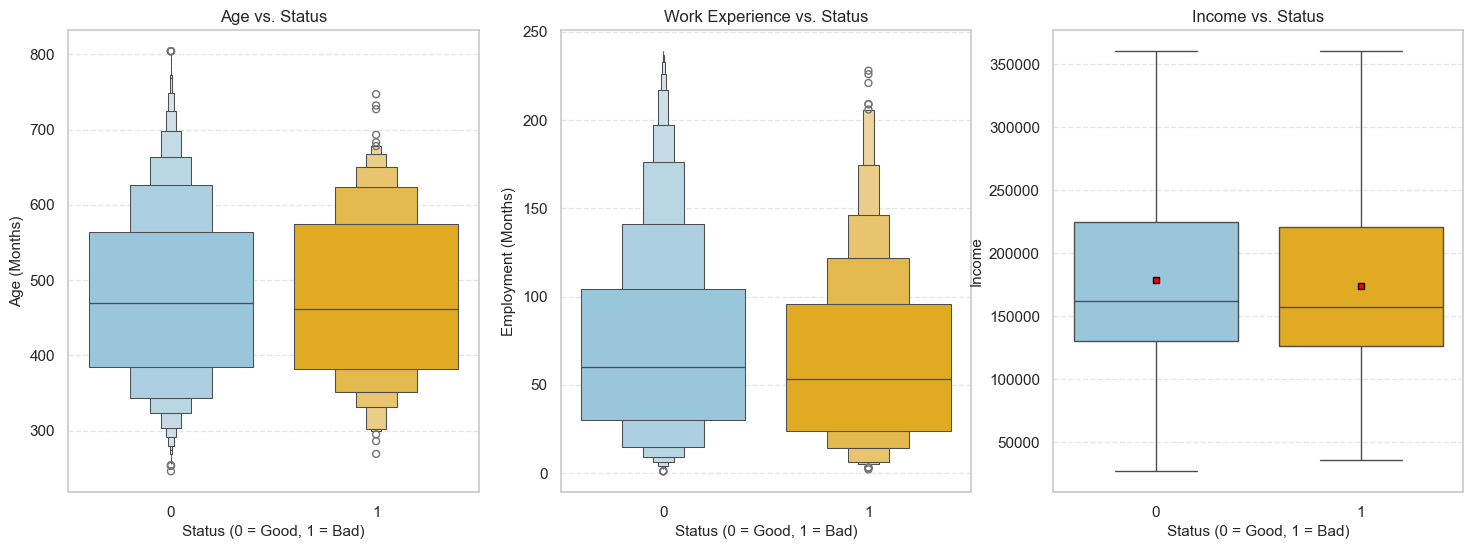

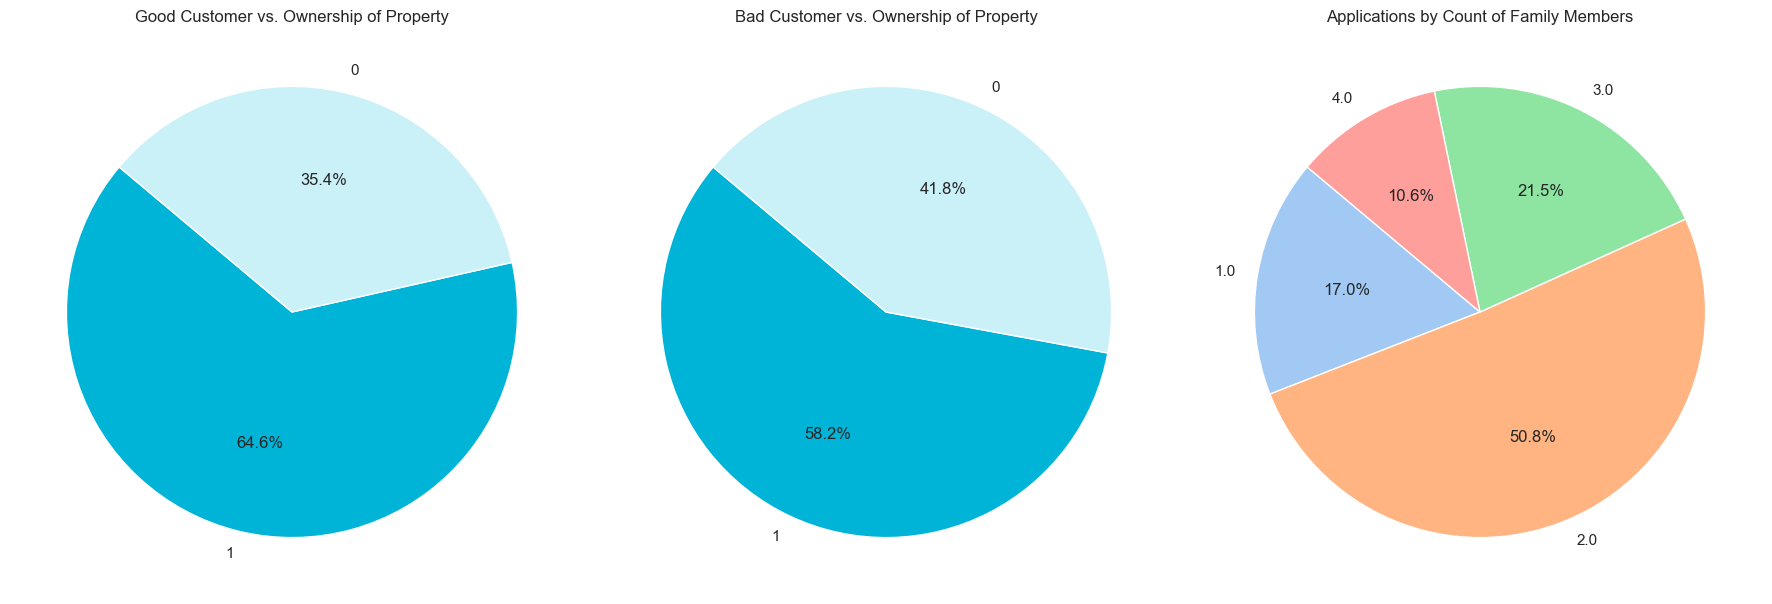

In [45]:
# Convert DAYS_BIRTH (negative day count) to a positive month count
# Using 30.4 days per month for a more precise conversion
if 'DAYS_BIRTH' in app_record_clean.columns:
    app_record_clean['age_months'] = (-app_record_clean['DAYS_BIRTH'] / 30.4).round(0)  # Round to whole months

# Convert DAYS_EMPLOYED (negative day count) to a positive month count
if 'DAYS_EMPLOYED' in app_record_clean.columns:
    app_record_clean['employment_months'] = (-app_record_clean['DAYS_EMPLOYED'] / 30.4).round(0)

print("Preview of final DataFrame:\n", app_record_clean.head())

sns.set_style("whitegrid")
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# 1) Age vs. Status (Boxen Plot)
sns.boxenplot(
    data=app_record_clean,
    x='target',
    y='age_months',
    hue='target',
    palette=['#8ecae6', '#ffb703'],
    ax=axes[0]
)
axes[0].set_title("Age vs. Status", fontsize=12)
axes[0].set_xlabel("Status (0 = Good, 1 = Bad)", fontsize=11)
axes[0].set_ylabel("Age (Months)", fontsize=11)
axes[0].grid(True, which='major', axis='y', linestyle='--', alpha=0.5)
axes[0].grid(False, which='major', axis='x')
if axes[0].get_legend() is not None:
    axes[0].legend_.remove()

# 2) Work Experience vs. Status (Boxen Plot)
sns.boxenplot(
    data=app_record_clean,
    x='target',
    y='employment_months',
    hue='target',
    palette=['#8ecae6', '#ffb703'],
    ax=axes[1]
)
axes[1].set_title("Work Experience vs. Status", fontsize=12)
axes[1].set_xlabel("Status (0 = Good, 1 = Bad)", fontsize=11)
axes[1].set_ylabel("Employment (Months)", fontsize=11)
axes[1].grid(True, which='major', axis='y', linestyle='--', alpha=0.5)
axes[1].grid(False, which='major', axis='x')
if axes[1].get_legend() is not None:
    axes[1].legend_.remove()


# Box Plot 3: Income vs. Status (with red square for average)
sns.boxplot(
    data=app_record_clean,
    x='target',
    y='AMT_INCOME_TOTAL',
    hue='target',  # same as x
    palette=['#8ecae6', '#ffb703'],
    showmeans=True,
    meanprops={
        'marker': 's',
        'markerfacecolor': 'red',  # specifically red for the mean
        'markeredgecolor': 'black',
        'markersize': 5
    },
    ax=axes[2]
)
axes[2].set_title("Income vs. Status", fontsize=12)
axes[2].set_xlabel("Status (0 = Good, 1 = Bad)", fontsize=11)
axes[2].set_ylabel("Income", fontsize=11)
axes[2].grid(True, which='major', axis='y', linestyle='--', alpha=0.5)
axes[2].grid(False, which='major', axis='x')
if axes[2].get_legend() is not None:
    axes[2].legend_.remove()


# ========== 2) Pie Charts for Property Ownership (Good vs. Bad) and Family Size ==========

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# (a) Good Customers vs. Ownership of Property
good_ownership = app_record_clean[app_record_clean['target'] == 0]['FLAG_OWN_REALTY'].value_counts()
axes[0].pie(
    good_ownership.values,
    labels=good_ownership.index,
    autopct='%1.1f%%',
    startangle=140,
    colors=['#00b4d8', '#caf0f8']  # example colors
)
axes[0].set_title("Good Customer vs. Ownership of Property", fontsize=12)

# (b) Bad Customers vs. Ownership of Property
bad_ownership = app_record_clean[app_record_clean['target'] == 1]['FLAG_OWN_REALTY'].value_counts()
axes[1].pie(
    bad_ownership.values,
    labels=bad_ownership.index,
    autopct='%1.1f%%',
    startangle=140,
    colors=['#00b4d8', '#caf0f8']
)
axes[1].set_title("Bad Customer vs. Ownership of Property", fontsize=12)

# (c) Applications by Family Members
fam_counts = app_record_clean['CNT_FAM_MEMBERS'].value_counts().sort_index()
axes[2].pie(
    fam_counts.values,
    labels=fam_counts.index,
    autopct='%1.1f%%',
    startangle=140,
    colors=sns.color_palette("pastel", n_colors=len(fam_counts))
)
axes[2].set_title("Applications by Count of Family Members", fontsize=12)

plt.tight_layout()
plt.show()

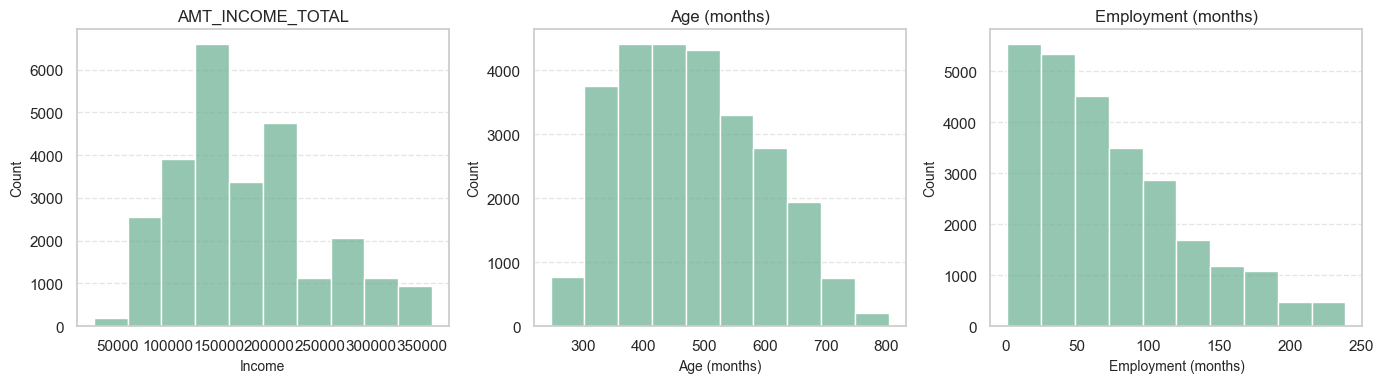

In [51]:
sns.set_style("whitegrid")

fig, axes = plt.subplots(1, 3, figsize=(14, 4))

# Histogram for Income with larger bins (fewer bins)
sns.histplot(data=app_record_clean, x='AMT_INCOME_TOTAL', ax=axes[0], color='#72b397', bins=10)
axes[0].set_title("AMT_INCOME_TOTAL", fontsize=12)
axes[0].set_xlabel("Income", fontsize=10)
axes[0].set_ylabel("Count", fontsize=10)
axes[0].grid(True, which='both', axis='y', linestyle='--', alpha=0.5)
axes[0].grid(False, which='both', axis='x')

# Histogram for Age (in months) with larger bins
sns.histplot(data=app_record_clean, x='age_months', ax=axes[1], color='#72b397', bins=10)
axes[1].set_title("Age (months)", fontsize=12)
axes[1].set_xlabel("Age (months)", fontsize=10)
axes[1].set_ylabel("Count", fontsize=10)
axes[1].grid(True, which='both', axis='y', linestyle='--', alpha=0.5)
axes[1].grid(False, which='both', axis='x')

# Histogram for Work Experience (in months) with larger bins
sns.histplot(data=app_record_clean, x='employment_months', ax=axes[2], color='#72b397', bins=10)
axes[2].set_title("Employment (months)", fontsize=12)
axes[2].set_xlabel("Employment (months)", fontsize=10)
axes[2].set_ylabel("Count", fontsize=10)
axes[2].grid(True, which='both', axis='y', linestyle='--', alpha=0.5)
axes[2].grid(False, which='both', axis='x')

plt.tight_layout()
plt.show()

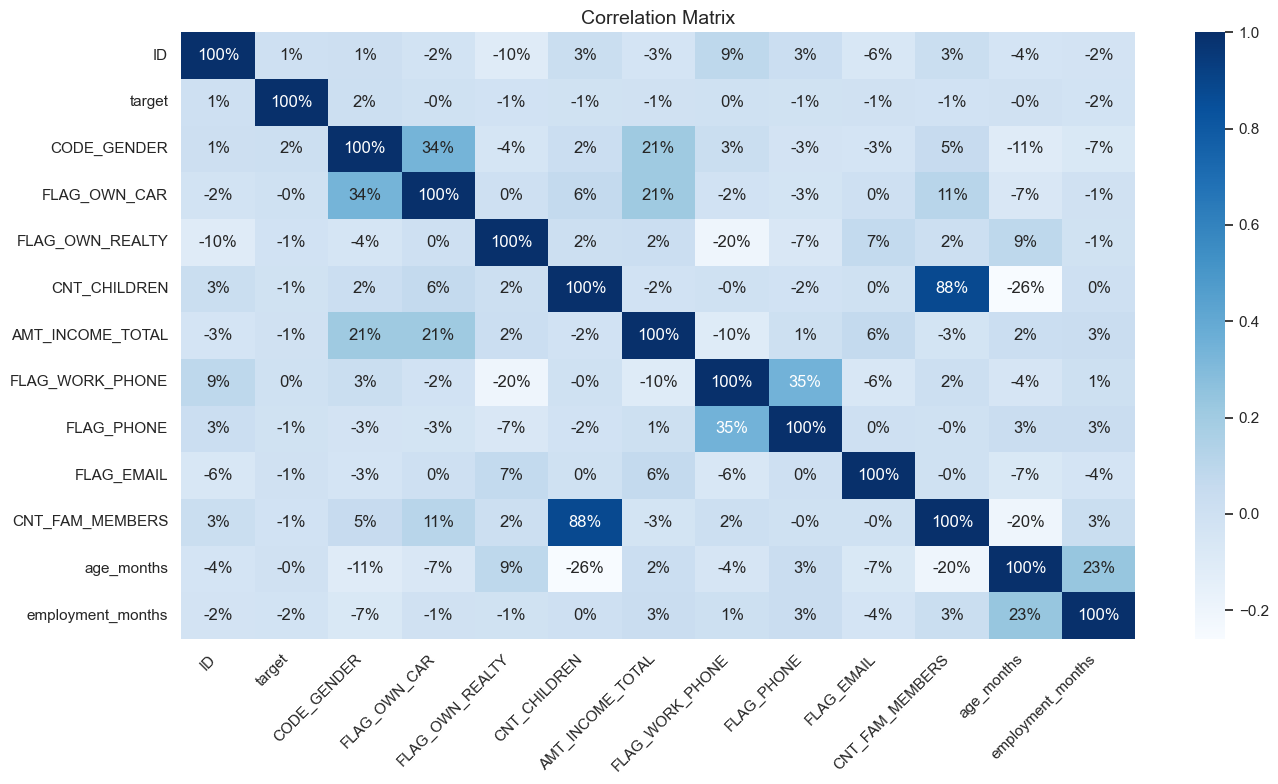

In [49]:
# Select columns for correlation (adjust as needed)
corr_cols = ['ID', 'target', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'FLAG_WORK_PHONE', 'FLAG_PHONE', 'FLAG_EMAIL', 'CNT_FAM_MEMBERS', 'age_months', 'employment_months'
]
df_corr = app_record_clean[corr_cols].dropna()

# Compute correlation matrix
corr_matrix = df_corr.corr()

plt.figure(figsize=(14, 8))
ax = sns.heatmap(
    corr_matrix,
    annot=True,
    cmap='Blues',
    fmt=".0%",  # Formats the correlation as a percentage with zero decimals
    square=False,
    cbar=True
)

# Remove vertical gridlines and set horizontal gridlines to dashed
ax.xaxis.grid(False)
ax.yaxis.grid(True, linestyle='--')

plt.title("Correlation Matrix", fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

### Pre-processing

This is where I think they applied SMOTE to the test set, as they mention: "According to our data, SMOTE can tackle the imbalanced target variance issue, and the testing data show that the distribution is likewise balanced, with 7355 “good customers” and 7473 “bad customers”. 

I did it too but I think this is wrong.

In [ ]:
# ------------------------------------------------------------------------
# 1) Split target from dataset
# ------------------------------------------------------------------------
X = df_corr.drop('target', axis=1)  # Features
y = df_corr['target']               # Labels

print("Before SMOTE:")
print("Overall label distribution (proportion):")
print(y.value_counts(normalize=True).round(3))
print("Pre SMOTE - Good customers:", y.value_counts()[0])
print("Pre SMOTE - Bad customers:", y.value_counts()[1])

# ------------------------------------------------------------------------
# 2) Oversample the entire dataset using SMOTE
# ------------------------------------------------------------------------

sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X, y)

print("\nAfter SMOTE:")
print("Overall label distribution (proportion):")
print(y_res.value_counts(normalize=True).round(3))
print("Post SMOTE - Good customers:", y_res.value_counts()[0])
print("Post SMOTE - Bad customers:", y_res.value_counts()[1])

# ------------------------------------------------------------------------
# 3) Split the oversampled dataset into Train and Test Sets (70:30)
# ------------------------------------------------------------------------

X_train, X_test, y_train, y_test = train_test_split(
    X_res, 
    y_res, 
    test_size=0.3,       # 30% for testing
    random_state=42,     # for reproducibility
    stratify=y_res       # preserve the balanced distribution
)

print("\nTrain set distribution (post SMOTE):")
print(y_train.value_counts(normalize=True).round(3))
print("Train set - Good customers:", y_train.value_counts()[0])
print("Train set - Bad customers:", y_train.value_counts()[1])

print("\nTest set distribution (post SMOTE):")
print(y_test.value_counts(normalize=True).round(3))
print("Test set - Good customers:", y_test.value_counts()[0])
print("Test set - Bad customers:", y_test.value_counts()[1])

Before SMOTE:
Overall label distribution (proportion):
target
0   0.988
1   0.012
Name: proportion, dtype: float64
Pre SMOTE - Good customers: 26340
Pre SMOTE - Bad customers: 323

After SMOTE:
Overall label distribution (proportion):
target
0   0.500
1   0.500
Name: proportion, dtype: float64
Post SMOTE - Good customers: 26340
Post SMOTE - Bad customers: 26340

Train set distribution (post SMOTE):
target
1   0.500
0   0.500
Name: proportion, dtype: float64
Train set - Good customers: 18438
Train set - Bad customers: 18438

Test set distribution (post SMOTE):
target
0   0.500
1   0.500
Name: proportion, dtype: float64
Test set - Good customers: 7902
Test set - Bad customers: 7902


/Users/tomasromeiro/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


### Initial attempt at XGBoost

In [ ]:
# ------------------------------------------------------------------------
# 1) Define XGBoost Classifier with the specified hyperparameters from paper
# ------------------------------------------------------------------------
xgb_clf = xgb.XGBClassifier(
    max_depth=12,
    n_estimators=250,
    min_child_weight=8,
    subsample=0.8,
    learning_rate=0.02,
    seed=60,
    gamma=0,
    colsample_bytree=0.8,
    objective="binary:logistic"
)

# ------------------------------------------------------------------------
# 2) Fit the model on the training set
# ------------------------------------------------------------------------
xgb_clf.fit(X_train, y_train)

# ------------------------------------------------------------------------
# 3) Make predictions on the test set
# ------------------------------------------------------------------------
y_pred = xgb_clf.predict(X_test)

# ------------------------------------------------------------------------
# 4) Evaluate the model
# ------------------------------------------------------------------------
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Accuracy: 0.9753

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.98      0.98      7902
           1       0.98      0.97      0.98      7902

    accuracy                           0.98     15804
   macro avg       0.98      0.98      0.98     15804
weighted avg       0.98      0.98      0.98     15804

Confusion Matrix:
[[7713  189]
 [ 202 7700]]
